### 2kb binned feature matrix analysis 
(top 60,000 features already selected.)

In [2]:
import os
import csv
import scipy
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import episcanpy.api as epi
%config InlineBackend.figure_format = "retina"
os.chdir("..")

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
adata = ad.read("data/epi/top60k_binned_2kb_count_matrix.h5ad")
adata

AnnData object with n_obs × n_vars = 19062 × 20002
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH', 'ArchR_doublet'
    var: 'transcript_annotation', 'n_cells'

In [4]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

In [6]:
adata.obs["log_nb_features"] = [np.log10(x) for x in adata.obs["nb_features"]]

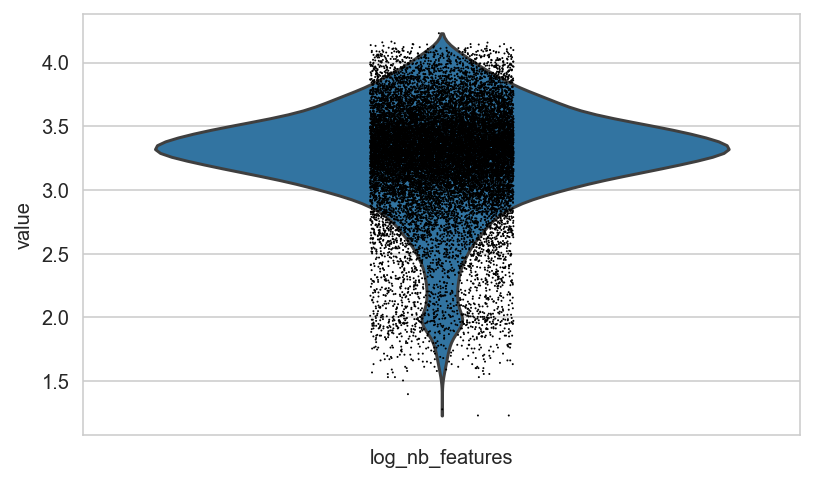

In [12]:
epi.pl.violin(adata, ["log_nb_features"])

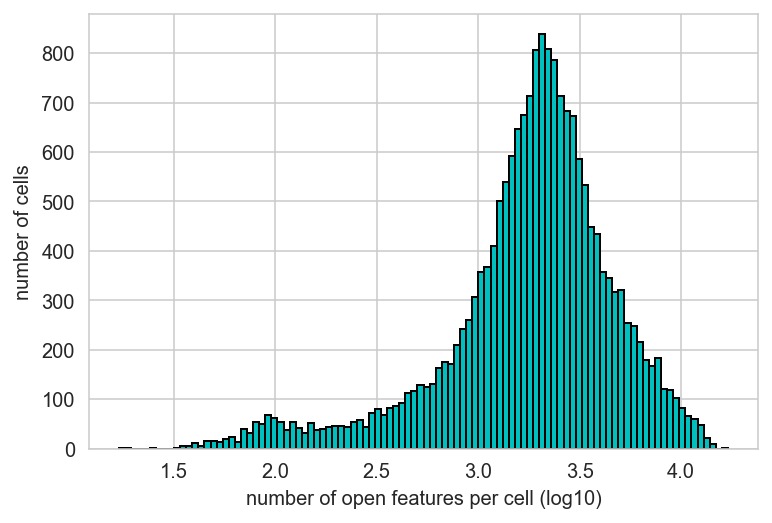

In [15]:
epi.pp.coverage_cells(adata,binary=True,log=10,bins=100)

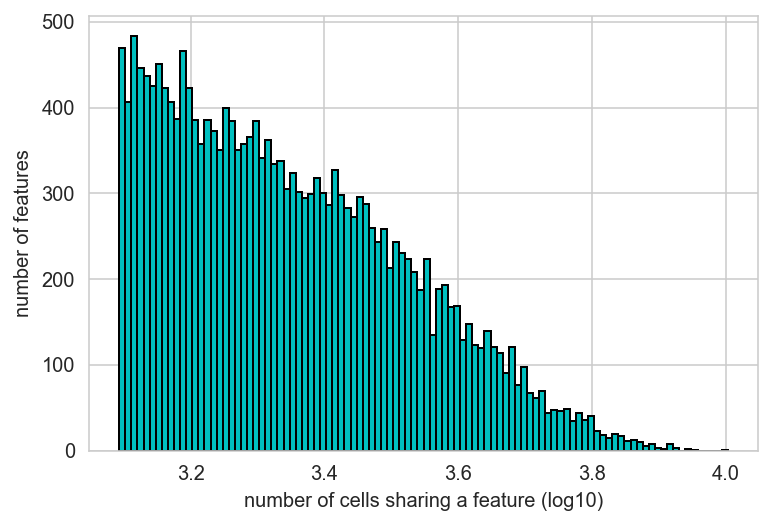

In [17]:
epi.pp.coverage_features(adata,binary=True,log=10,bins=100)  # looks funky because of the hard cut-off done earlier

In [23]:
epi.pp.filter_cells(adata, min_features=500) #all cells should have >=500 features
adata.raw = adata

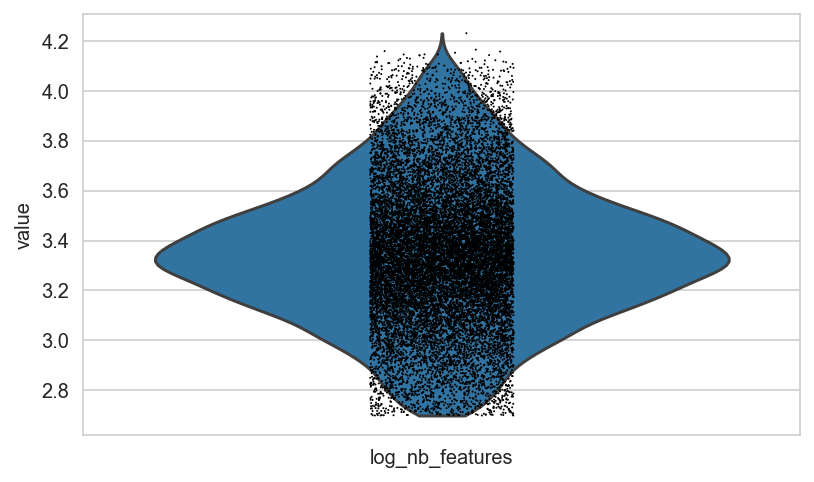

In [24]:
epi.pl.violin(adata, ['log_nb_features'])

In [26]:
np.min(adata.var["n_cells"])

1238.0

In [27]:
adata_MK_norm = adata

def TFIDF(x):
    tf_x = np.divide(x, x.sum(0))
    idf_x = np.diag(np.log(1 + (np.shape(x)[1]) / x.sum(1)))
    tfidf_x = np.dot(tf_x.T, idf_x).T
    return tfidf_x
X = adata.X.T  #transpose anndata matrix to get cells as columns
tfidf_X = TFIDF(X.toarray())  # convert to nparray and run TF-IDF
adata_MK_norm.X = scipy.sparse.csr_matrix(tfidf_X).T #convert back to scipy.sparse and transpose to get cells as rows

In [29]:
adata_MK_norm

AnnData object with n_obs × n_vars = 17245 × 20002
    obs: 'NGI_ID', 'ProcessNumber', 'caseNO', 'Tissue', 'Sex', 'Age', 'PMI', 'MK_ID', '10X_BATCH', 'NGS_BATCH', 'ArchR_doublet', 'nb_features', 'log_nb_features'
    var: 'transcript_annotation', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

In [30]:
epi.pp.lazy(adata_MK_norm)

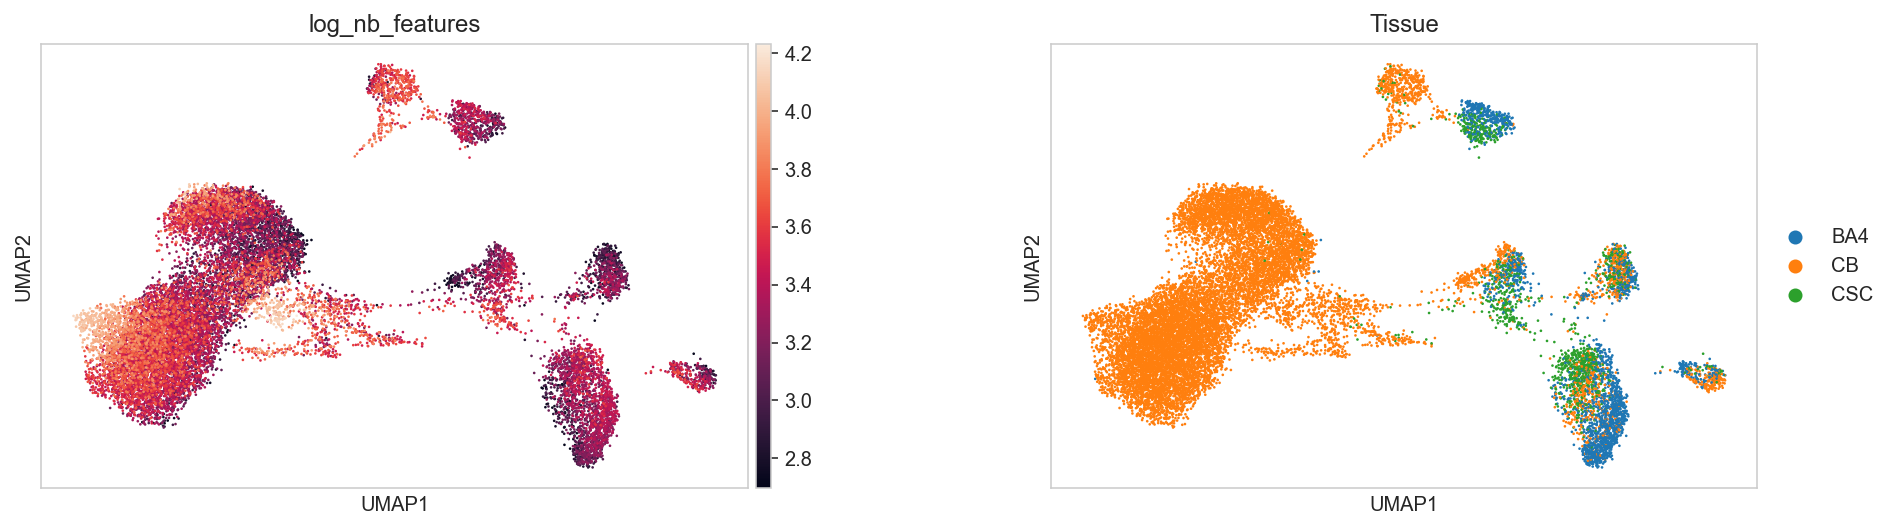

In [43]:
sc.pl.umap(adata_MK_norm, color=["log_nb_features", "Tissue"], wspace=0.3)

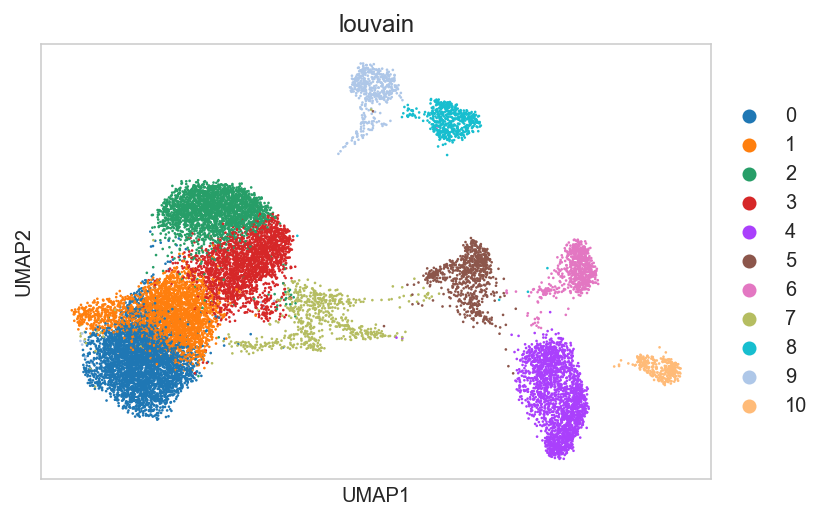

In [56]:
epi.tl.louvain(adata_MK_norm)
epi.pl.umap(adata_MK_norm, color = ["louvain"])

In [60]:
sc.tl.dendrogram(adata_MK_norm, groupby = "louvain")

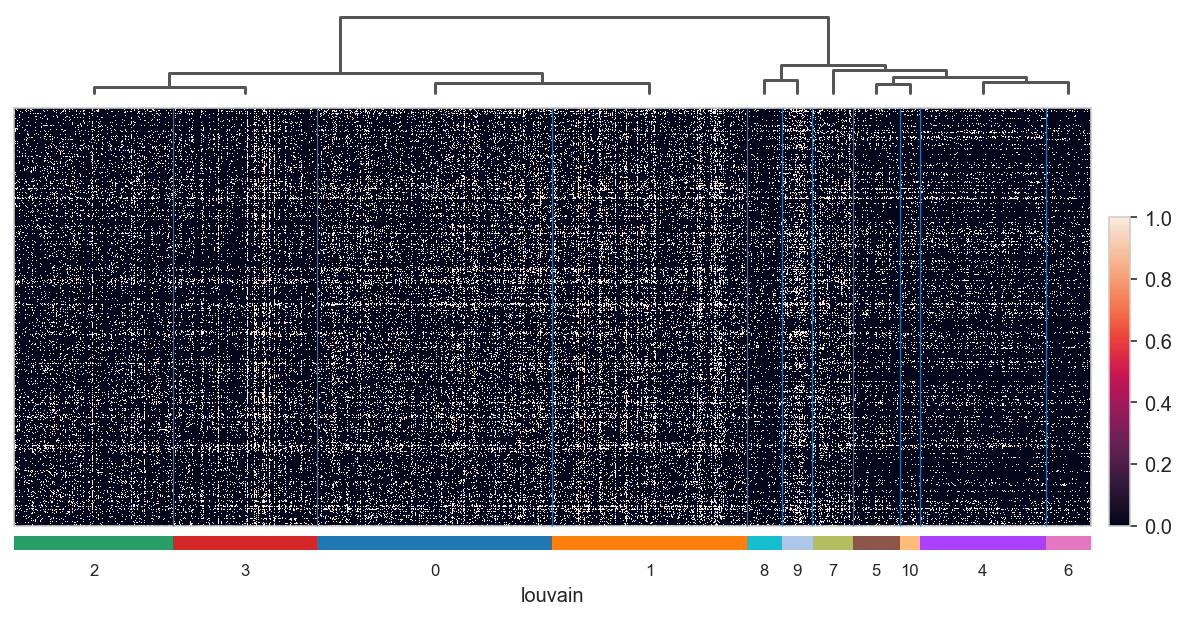

In [68]:
sc.pl.heatmap(adata_MK_norm, var_names = adata_MK_norm.var_names, groupby = "louvain", dendrogram=True, swap_axes=True)

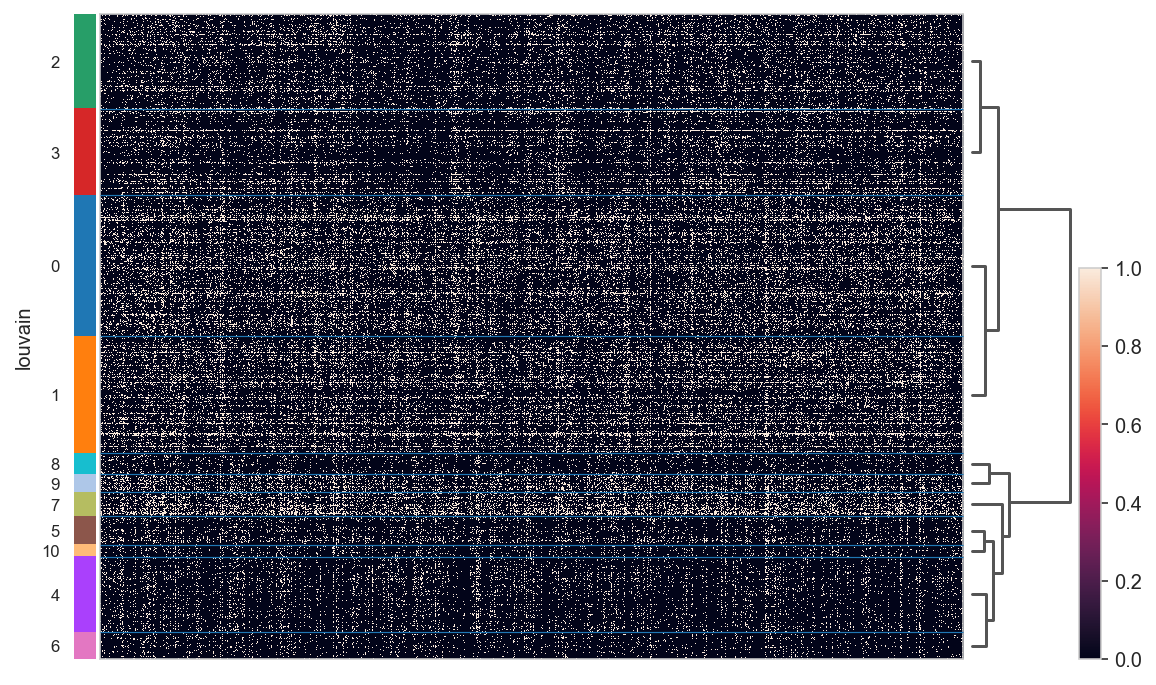

In [73]:
sc.pl.heatmap(adata_MK_norm, var_names = adata_MK_norm.var_names, groupby = "louvain", dendrogram=True)

In [72]:
len(adata.obsm["X_pca"])

17245